In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

from keras.layers import Input,Lambda,Dense,Flatten,Conv2D,MaxPooling2D, Dropout
from keras.models import Model,Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


from keras.models import Model
from keras.layers import Activation
from keras import backend as K
# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


In [2]:
image_size=[224,224]
train_path='D:/Courses/CSC3180/Project/demo/datasets/chest_xray/train'
test_path='D:/Courses/CSC3180/Project/demo/datasets/chest_xray/test'

In [3]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [4]:
train_data=train_datagen.flow_from_directory(train_path,target_size=(224,224),batch_size=32,class_mode='categorical')

Found 5232 images belonging to 2 classes.


In [5]:
test_data=test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,class_mode='categorical')

Found 624 images belonging to 2 classes.


In [6]:
## CNN Model
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax')) 
# model.add(Dense(2,activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [9]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
## Previous Epoch 25 takes about 40mins for training
model.fit(train_data,validation_data=test_data,epochs=15)

Epoch 1/15
164/164 [==============================] - 100s 612ms/step - loss: 0.4995 - accuracy: 0.7773 - val_loss: 0.4941 - val_accuracy: 0.8109
Epoch 2/15
164/164 [==============================] - 92s 559ms/step - loss: 0.3171 - accuracy: 0.8505 - val_loss: 0.3545 - val_accuracy: 0.8574
Epoch 3/15
164/164 [==============================] - 94s 573ms/step - loss: 0.2762 - accuracy: 0.8714 - val_loss: 0.3615 - val_accuracy: 0.8381
Epoch 4/15
164/164 [==============================] - 93s 565ms/step - loss: 0.2767 - accuracy: 0.8899 - val_loss: 0.3986 - val_accuracy: 0.8686
Epoch 5/15
164/164 [==============================] - 94s 572ms/step - loss: 0.2545 - accuracy: 0.9018 - val_loss: 0.3087 - val_accuracy: 0.8429
Epoch 6/15
164/164 [==============================] - 91s 553ms/step - loss: 0.2266 - accuracy: 0.9184 - val_loss: 0.1915 - val_accuracy: 0.8606
Epoch 7/15
164/164 [==============================] - 91s 554ms/step - loss: 0.2361 - accuracy: 0.9042 - val_loss: 0.1455 - val_a

In [10]:
model.save('./models/pneumonia-detection-model-epoches-15')

In [7]:
from keras.models import load_model
model = load_model('./models/pneumonia-detection-model-epoches-15')

In [8]:
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from PIL import Image

# 0 - Tumor
# 1 - Normal
encoder = OneHotEncoder()
encoder.fit([[0], [1]]) 

## Model Evaluation
data = []
result = []

paths = []

for r, d, f in os.walk(r'D:/Courses/CSC3180/Project/demo/datasets/chest_xray/train/NORMAL'):
    for file in f:
        if '.jpeg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
  img = Image.open(path)
  img = img.resize((224, 224))
  img = np.array(img)
  if(img.shape == (224,224,3)):
      data.append(np.array(img))
      result.append(encoder.transform([[0]]).toarray())
  # data.append(np.array(img))
  # result.append(encoder.transform([[0]]).toarray())

print('test normal paths num: ', len(paths))

paths = []

for r, d, f in os.walk(r'D:/Courses/CSC3180/Project/demo/datasets/chest_xray/train/PNEUMONIA'):
    for file in f:
        if '.jpeg' in file:
            paths.append(os.path.join(r, file))

print('test pneumonia paths num: ', len(paths))

for path in paths:
  img = Image.open(path)
  img = img.resize((224, 224))
  img = np.array(img)
  if(img.shape == (224,224,3)):
      data.append(np.array(img))
      result.append(encoder.transform([[1]]).toarray())
  # data.append(np.array(img))
  # result.append(encoder.transform([[1]]).toarray())

test normal paths num:  1349
test pneumonia paths num:  3883


In [10]:
data = np.array(data)
data.shape

(283, 224, 224, 3)

In [11]:
result = np.array(result)
result = result.reshape(283, 2)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, result, test_size=0.9, shuffle=True, random_state=0)

In [13]:
score = model.evaluate(test_data, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1102244034409523
Test accuracy: 0.8653846383094788


In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0
Test accuracy: 1.0


In [16]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test[0:15]
    ys = y_test[0:15]
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    # attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    # attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    # attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)

Wall time: 15.6 s


Wall time: 2.4 s


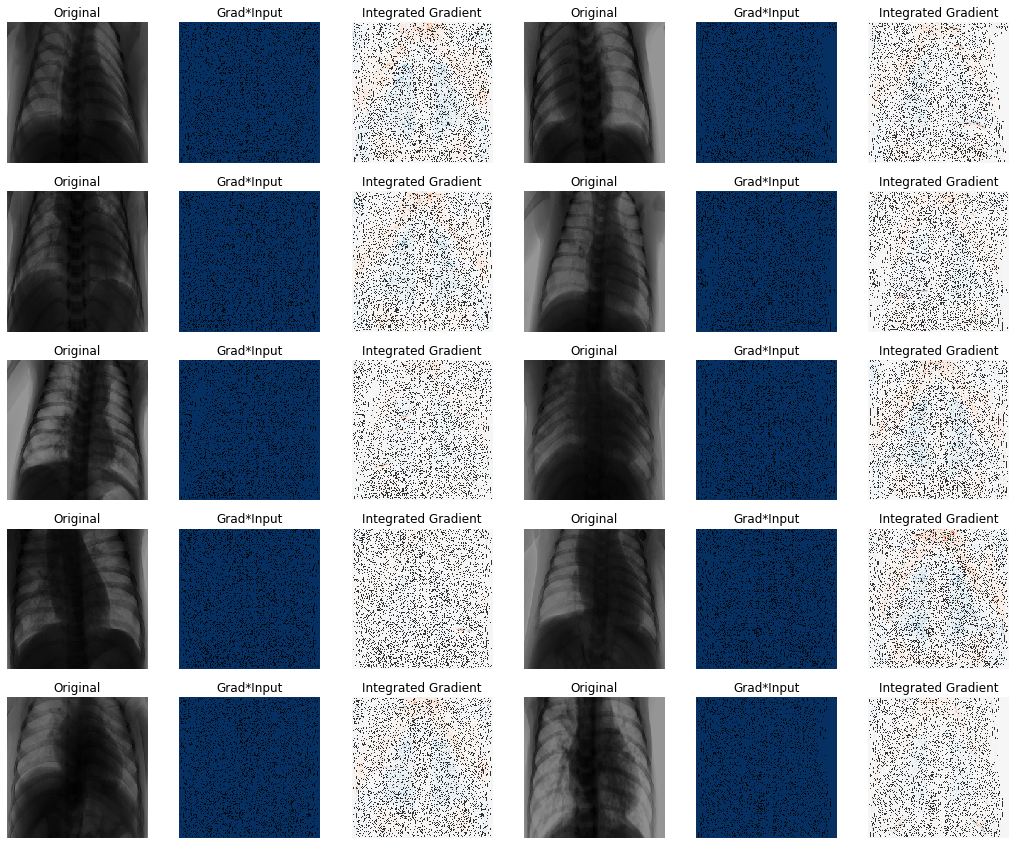

In [71]:
%%time
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_gradin) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_gradin, attributions_ig)):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(224, 224, 3), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(a1.reshape(224, 224, 3), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
    plot(a2.reshape(224, 224, 3), xi = xs[i], axis=axes[row,col*3+2]).set_title('Integrated Gradient')

Wall time: 12 s


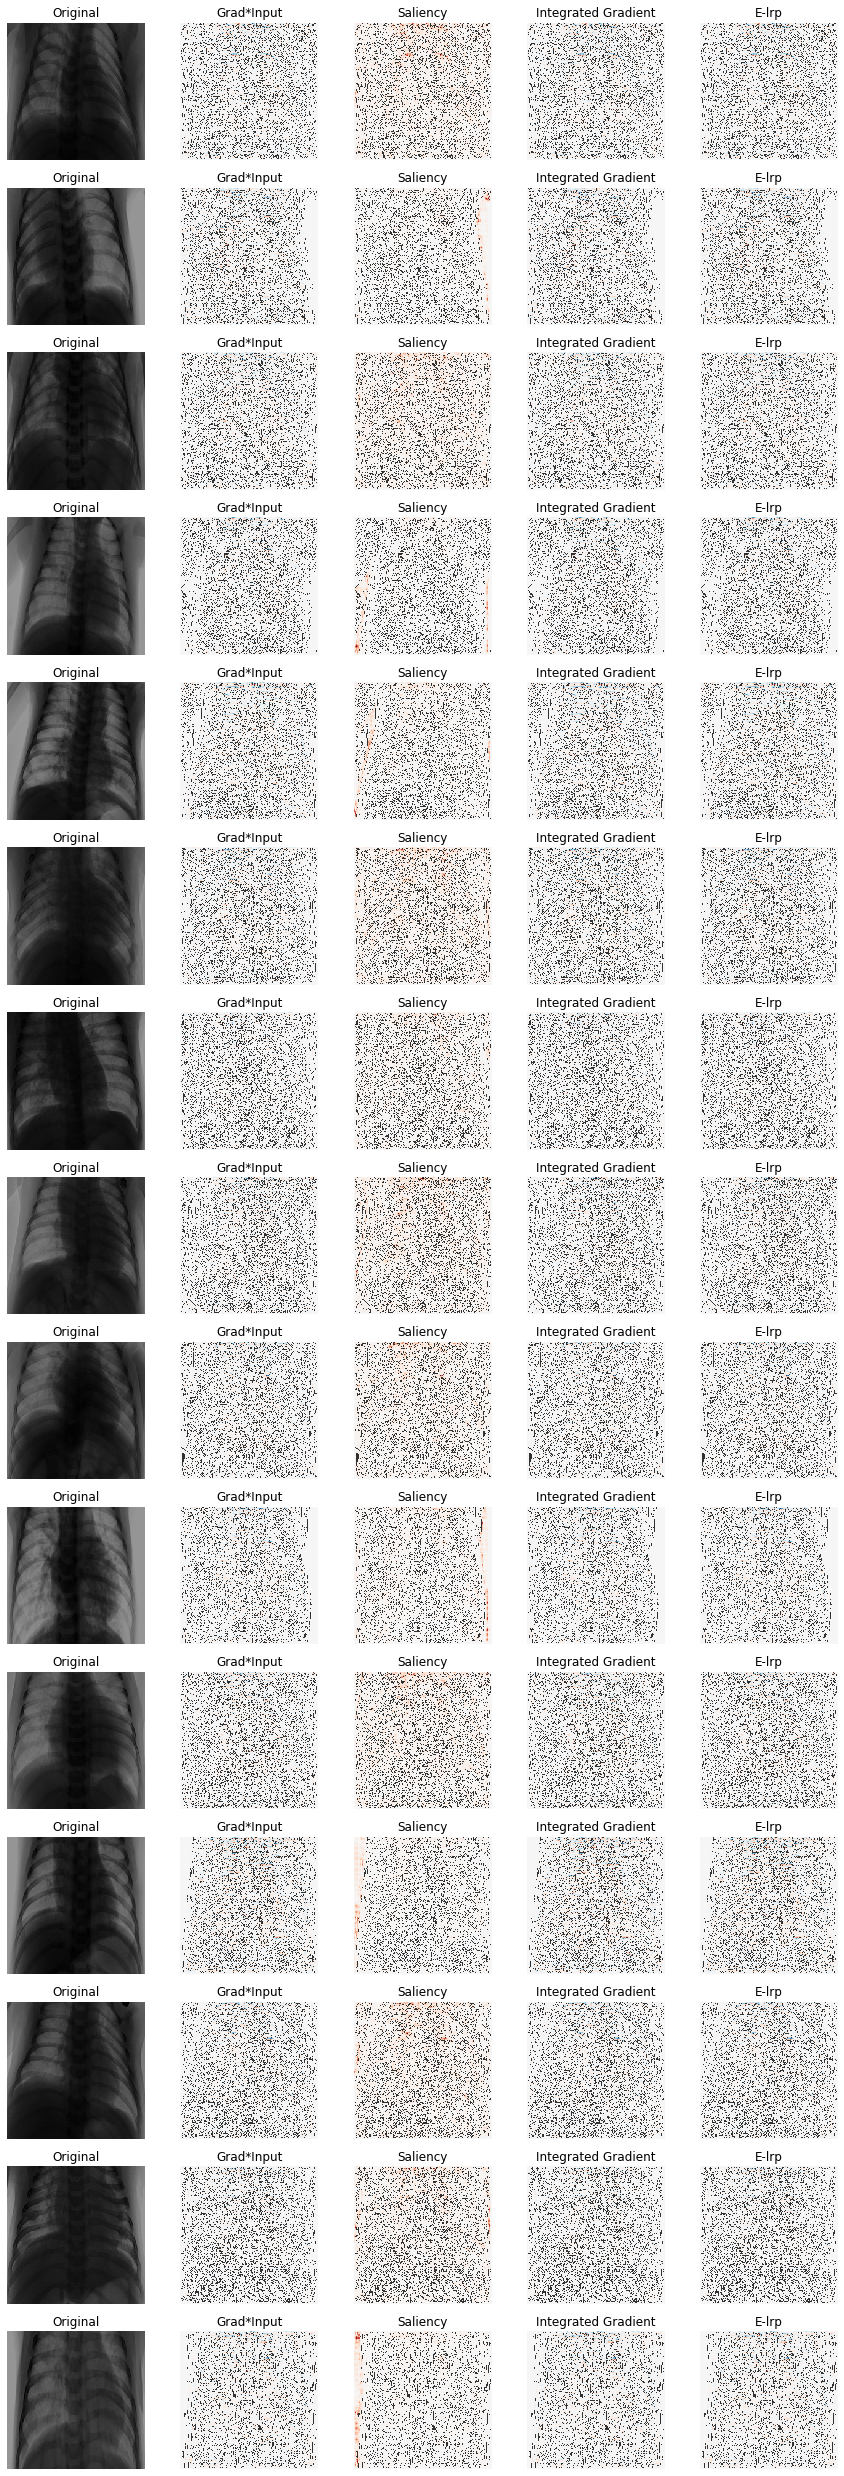

In [17]:
%%time
from utils import plot, plt
%matplotlib inline

n_cols = 5
n_rows = int(len(attributions_gradin))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (gradin, sal, ig, elrp) in enumerate(zip(attributions_gradin, attributions_sal, attributions_ig, attributions_elrp)):
    # row, col = divmod(i, 2)
    row = i
    col = 0
    plot(xs[i].reshape(224, 224, 3), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(gradin.reshape(224, 224, 3), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
    plot(sal.reshape(224, 224, 3), xi = xs[i], axis=axes[row,col*3+2]).set_title('Saliency')
    plot(ig.reshape(224, 224, 3), xi = xs[i], axis=axes[row,col*3+3]).set_title('Integrated Gradient')
    plot(elrp.reshape(224, 224, 3), xi = xs[i], axis=axes[row,col*3+4]).set_title('E-lrp')
    